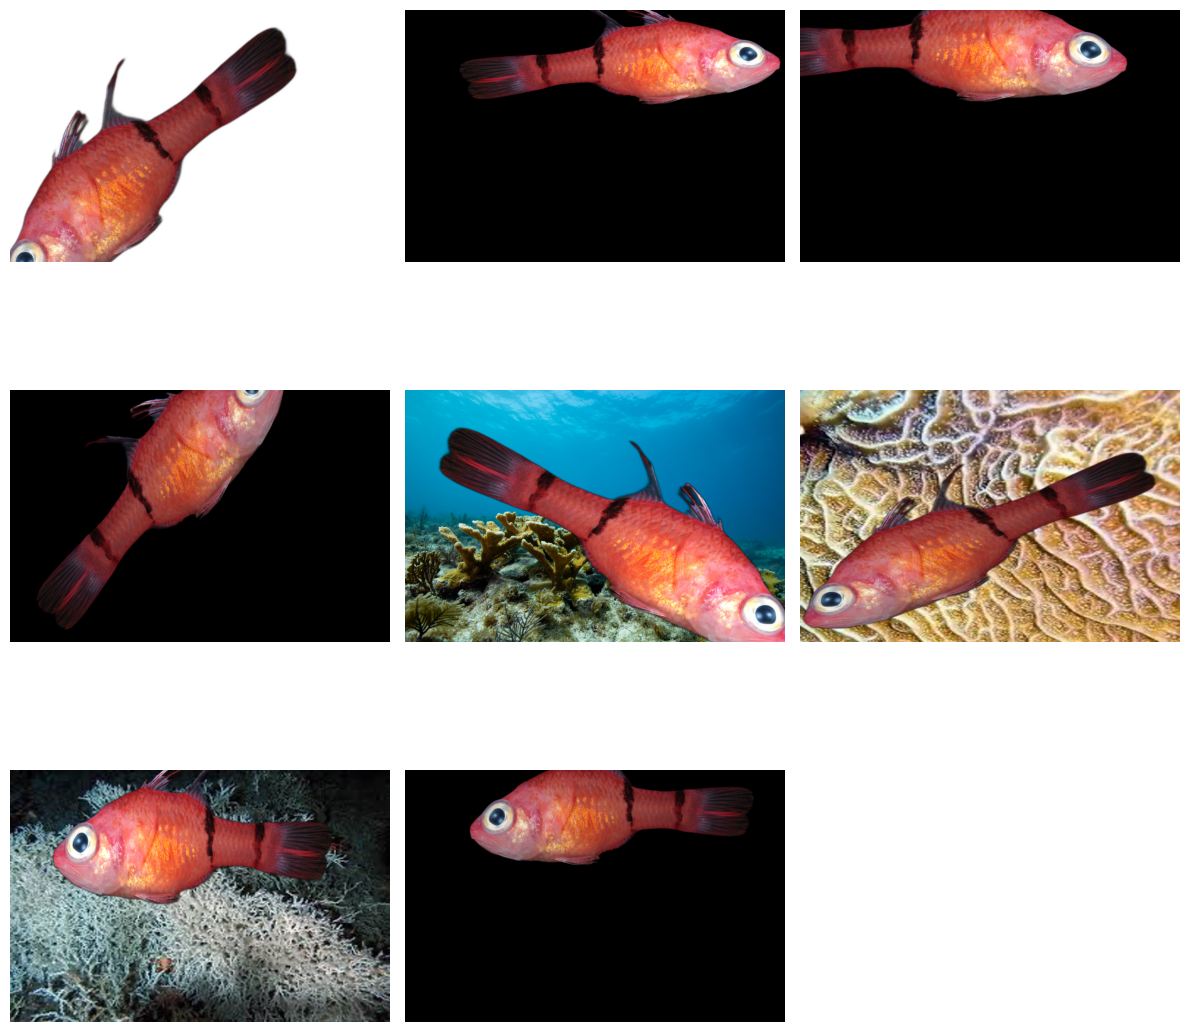

In [59]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from rembg import remove

import matplotlib.pyplot as plt

def is_image_file(file_name):
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    return file_name.lower().endswith(valid_extensions) and not file_name.startswith('.')

def augment_image(
    image_path: str, 
    num_variations: int, 
    background_dir: str = None, 
    rotation_range=45, 
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    shear_range=0.25, 
    zoom_range=(0.75, 1.35), 
    horizontal_flip=True,
    vertical_flip=False, 
    brightness_range=(0.7, 1.3), 
    fill_mode='nearest', 
    bg_choices=('black', 'white', 'image'), 
    bg_probabilities=(0.4, 0.35, 0.25)
):
    image = Image.open(image_path)
    image = remove(image)
    
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        brightness_range=brightness_range,
        fill_mode=fill_mode
    )

    image_array = np.array(image).reshape((1,) + np.array(image).shape)  # Ensure correct shape

    augmented_images = []
    if background_dir:
        background_files = [f for f in os.listdir(background_dir) if is_image_file(f)]

    for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
        aug_image = Image.fromarray(batch[0].astype('uint8'))

        if background_dir:
            choice = random.choices(bg_choices, bg_probabilities)[0]
        else:
            choice = random.choice(('black', 'white'))

        if choice == 'black':
            background = Image.new('RGB', aug_image.size, (0, 0, 0))
        elif choice == 'white':
            background = Image.new('RGB', aug_image.size, (255, 255, 255))
        elif choice == 'image':
            bg_image_path = random.choice(background_files)
            background = Image.open(os.path.join(background_dir, bg_image_path)).resize(aug_image.size)

        background.paste(aug_image, (0, 0), aug_image)
        aug_image = background
        
        augmented_images.append(aug_image)
        if i + 1 >= num_variations:
            break
    
    return augmented_images

def plot_augmented_images(augmented_images):
    # Determine the grid size
    num_images = len(augmented_images)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    # Create a figure to hold the subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()

    # Plot each augmented image
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(augmented_images[i])
            ax.axis('off')
        else:
            ax.remove()  # Remove empty subplots

    plt.tight_layout()
    plt.show()

# Example usage:
augmented_images = augment_image(
    '/CryptoVision/data/Apogonidae_Apogon_binotatus/63236389_fish_photo_16842.png', 
    8,
    "/CryptoVision/coral_reef_bg"
)
plot_augmented_images(augmented_images)

In [1]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from rembg import remove

def augment_image(image_path, num_variations, background_dir, apply_background=False):
    def is_image_file(file_path):
        try:
            Image.open(file_path)
            return True
        except UnidentifiedImageError:
            return False

    # Load and optionally remove background
    image = Image.open(image_path)
    if apply_background:
        image = remove(image)
    
    # Set up the image data generator with the specified augmentations
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=[0.85, 1.35],
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        fill_mode='nearest'
    )

    # Convert image to array
    image_array = np.array(image)
    image_array = image_array.reshape((1,) + image_array.shape)
    
    # Directory for augmented images
    augmented_images = []

    # Filter background images
    background_files = [f for f in os.listdir(background_dir) if is_image_file(os.path.join(background_dir, f))]

    # Generate augmented images
    i = 0
    for batch in datagen.flow(image_array, batch_size=1):
        # Convert array back to image
        aug_image = Image.fromarray(batch[0].astype('uint8'))

        if apply_background:
            # Apply random background with specified probabilities
            choice = random.choices(['black', 'white', 'image'], [0.5, 0.35, 0.15])[0]
            
            if choice == 'black':
                bg_color = (0, 0, 0)
                background = Image.new('RGB', aug_image.size, bg_color)
            elif choice == 'white':
                bg_color = (255, 255, 255)
                background = Image.new('RGB', aug_image.size, bg_color)
            else:
                bg_image_path = random.choice(background_files)
                background = Image.open(os.path.join(background_dir, bg_image_path)).resize(aug_image.size)
            
            background.paste(aug_image, (0, 0), aug_image)
            augmented_images.append(background)
        else:
            augmented_images.append(aug_image)

        i += 1
        if i >= num_variations:
            break
    
    return augmented_images

def augment_dataset(source_dir, target_dir, background_dir, apply_background=False, total_images=500):
    def is_image_file(file_path):
        try:
            Image.open(file_path)
            return True
        except UnidentifiedImageError:
            return False

    # Create the target directory if it doesn't exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Iterate through each sub-folder in the source directory
    for species_folder in tqdm(os.listdir(source_dir), desc="Processing species folders"):
        species_path = os.path.join(source_dir, species_folder)
        target_species_path = os.path.join(target_dir, species_folder)

        if os.path.isdir(species_path):
            # Check if the species folder already exists in the target directory
            if os.path.exists(target_species_path) and len(os.listdir(target_species_path)) >= total_images:
                tqdm.write(f"Skipping {species_folder} as it is already processed.")
                continue

            # Create the corresponding species folder in the target directory
            if not os.path.exists(target_species_path):
                os.makedirs(target_species_path)

            # Count the number of original images
            original_images = [f for f in os.listdir(species_path) if is_image_file(os.path.join(species_path, f))]
            num_original_images = len(original_images)
            
            # Calculate the number of augmentations per original image to reach the total_images
            if num_original_images == 0:
                continue  # Skip empty folders
            num_augmentations_per_image = total_images // num_original_images
            additional_images_needed = total_images - (num_original_images * num_augmentations_per_image)

            # Augment images
            for image_file in tqdm(original_images, desc=f"Augmenting {species_folder}", leave=False):
                image_path = os.path.join(species_path, image_file)
                augmented_images = augment_image(image_path, num_augmentations_per_image, background_dir, apply_background)
                
                # Save augmented images
                for idx, aug_image in enumerate(augmented_images):
                    aug_image.save(os.path.join(target_species_path, f"{os.path.splitext(image_file)[0]}_aug_{idx}.png"))
                
                # Add additional augmentations if needed
                if additional_images_needed > 0:
                    extra_augmented_images = augment_image(image_path, additional_images_needed, background_dir, apply_background)
                    for idx, aug_image in enumerate(extra_augmented_images):
                        aug_image.save(os.path.join(target_species_path, f"{os.path.splitext(image_file)[0]}_extra_aug_{idx}.png"))
                    additional_images_needed -= len(extra_augmented_images)

augment_dataset(
    '/CryptoVision/data', 
    '/CryptoVision/augmented_v2', 
    '/CryptoVision/coral_reef_bg', 
    apply_background=True,
    total_images=250,
)

Skipping Labridae_Halichoeres_claudia as it is already processed.
Skipping Labridae_Labroides_dimidiatus as it is already processed.
Skipping Plesiopidae_Assessor_flavissimus as it is already processed.
Skipping Gobiidae_Lythrypnus_nesiotes as it is already processed.
Skipping Monacanthidae_Monacanthus_tuckeri as it is already processed.
Skipping Pomacanthidae_Centropyge_flavissima as it is already processed.
Skipping Pomacanthidae_Centropyge_bispinosa as it is already processed.
Skipping Gobiidae_Eviota_nebulosa as it is already processed.
Skipping Sciaenidae_Eques_punctatus as it is already processed.
Skipping Creediidae_Limnichthys_nitidus as it is already processed.
Skipping Labridae_Gomphosus_varius as it is already processed.
Skipping Serranidae_Pseudogramma_polyacantha as it is already processed.
Skipping Tripterygiidae_Helcogramma_fuscopinna as it is already processed.
Skipping Gobiidae_Eviota_teresae as it is already processed.
Skipping Blenniidae_Ecsenius_pulcher as it is alr

Processing species folders:  51%|█████     | 38/75 [00:00<00:00, 183.59it/s]

Skipping Scorpaenidae_Scorpaenodes_kelloggi as it is already processed.
Skipping Scorpaenidae_Caracanthus_unipinna as it is already processed.
Skipping Syngnathidae_Corythoichthys_flavofasciatus as it is already processed.
Skipping Dinematichthyidae_Ogilbia_ as it is already processed.
Skipping Gobiidae_Gobiodon_histrio as it is already processed.
Skipping Pseudochromidae_Pseudochromis_revellei as it is already processed.
Skipping Pseudochromidae_Pseudochromis_flammicauda as it is already processed.
Skipping Pomacentridae_Chromis_margaritifer as it is already processed.
Skipping Plesiopidae_Plesiops_coeruleolineatus as it is already processed.
Skipping Gobiidae_Eviota_melasma as it is already processed.
Skipping Gobiidae_Pleurosicya_labiata as it is already processed.
Skipping Labridae_Pseudocheilinus_tetrataenia as it is already processed.
Skipping Tripterygiidae_Enneapterygius_ventermaculus as it is already processed.


Processing species folders: 100%|██████████| 75/75 [28:51<00:00, 23.09s/it] 


In [3]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from rembg import remove

def is_image_file(file_name:str, valid_extensions:tuple[str]=('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
    return file_name.lower().endswith(valid_extensions) and not file_name.startswith('.')


background_files = [f for f in os.listdir("/Users/leonardo/Pictures/sample_fish") if is_image_file(f)]

print(background_files)

['download.jpeg', 'download (3).jpeg', 'images.jpeg', 'download (1).jpeg', 'download copy.jpeg', 'download (2).jpeg', 'eviota_malasma.jpeg', 'fixed.png']


In [62]:
import os

os.listdir("/CryptoVision/data")

['Labridae_Halichoeres_claudia',
 'Labridae_Labroides_dimidiatus',
 'Plesiopidae_Assessor_flavissimus',
 'Gobiidae_Lythrypnus_nesiotes',
 'Monacanthidae_Monacanthus_tuckeri',
 'Pomacanthidae_Centropyge_flavissima',
 'Pomacanthidae_Centropyge_bispinosa',
 'Gobiidae_Eviota_nebulosa',
 'Sciaenidae_Eques_punctatus',
 'Creediidae_Limnichthys_nitidus',
 '.DS_Store',
 '._.DS_Store',
 'Labridae_Gomphosus_varius',
 'Serranidae_Pseudogramma_polyacantha',
 'Tripterygiidae_Helcogramma_fuscopinna',
 'Gobiidae_Eviota_teresae',
 'Blenniidae_Ecsenius_pulcher',
 'Gobiidae_Paragobiodon_lacunicolus',
 'Gobiidae_Trimma_capostriatum',
 'Gobiidae_Eviota_monostigma',
 'Cirrhitidae_Paracirrhites_arcatus',
 'Apogonidae_Pristiapogon_kallopterus',
 'Pomacentridae_Pomacentrus_amboinensis',
 'Dactyloscopidae_Gillellus_uranidae',
 'Chaenopsidae_Acanthemblemaria_aspera',
 'Tripterygiidae_Enneanectes_matador',
 'Gobiidae_Eviota_prasites',
 'Gobiesocidae_Acyrtus_lanthanum',
 'Scorpaenidae_Sebastapistes_fowleri',
 'Pse